{'11': 524, '00': 500}


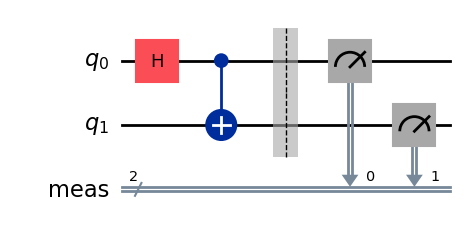

In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

backend = AerSimulator()
compiled_circuit = transpile(qc, backend)
job = backend.run(compiled_circuit, shots=1024)
result = job.result()

counts = result.get_counts()
print(counts)
qc.draw('mpl')

/var/folders/pp/vfc9qwjn6zj_6n_xhdmtvsgr0000gn/T/ipykernel_87971/321073062.py:10: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel='ibm_quantum', token=token)


IBM Quantum Runtime Service에 연결되었습니다.

사용 가능한 백엔드 목록:
- 이름: ibm_brisbane, 상태: Operational, 큐비트 수: 127
- 이름: ibm_sherbrooke, 상태: Operational, 큐비트 수: 127

선택된 백엔드 객체: ibm_brisbane

Runtime Sampler를 사용하여 백엔드 'ibm_brisbane'에서 회로를 실행합니다...
Sampler 작업 ID: d0fan1c36cs0008r4cb0
작업이 완료될 때까지 기다립니다...

측정 결과 (Counts):
{'010': 7, '011': 118, '000': 129, '001': 2}


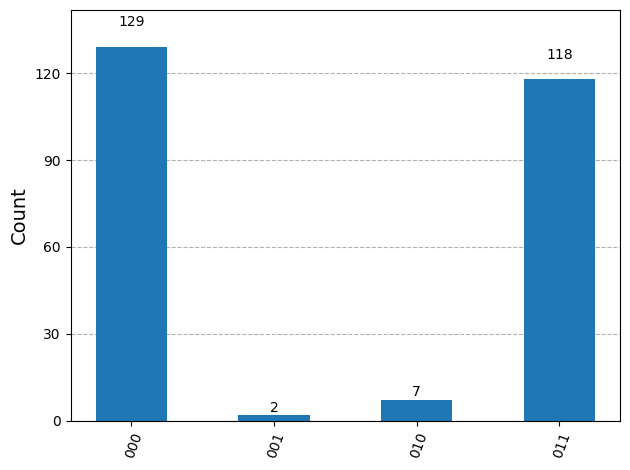

In [7]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
from qiskit.visualization import plot_histogram

token = '305e471266b0db457d340a56e115563920d06ea4046cc76f3f1139a377cabb925155287ab75a77c0885b605aa1535d340143b1bcf461d3a8ef3a516c93ce0b08'

# 1. IBM Quantum 계정 로드 및 Runtime Service 객체 생성

try:
    service = QiskitRuntimeService(channel='ibm_quantum', token=token)
    print("IBM Quantum Runtime Service에 연결되었습니다.")
except Exception as e:
    print(f"IBM Quantum Runtime Service 연결 오류: {e}")
    print("계정 정보가 올바르게 저장되었거나, token을 직접 입력했는지 확인하세요.")
    exit() # 연결 실패 시 스크립트 종료

# 2. 백엔드 설정
available_backends = service.backends(simulator=False, operational=True)

print("\n사용 가능한 백엔드 목록:")
if available_backends:
    for backend in available_backends:
        print(f"- 이름: {backend.name}, 상태: {'Operational' if backend.status().operational else 'Non-operational'}, 큐비트 수: {backend.num_qubits if hasattr(backend, 'num_qubits') else 'N/A'}")
else:
    print("사용 가능한 백엔드가 없습니다. 계정 상태를 확인하거나 접근 권한이 있는지 확인하세요.")

backend_name = available_backends[0].name

try:
    backend = service.backend(backend_name) # <-- 백엔드 이름으로 객체를 가져옴
    print(f"\n선택된 백엔드 객체: {backend.name}")
except Exception as e:
    print(f"\n오류: 백엔드 '{backend_name}'를 찾거나 접근할 수 없습니다.")
    print(e)
    exit() # 백엔드를 찾지 못하면 종료

# 3. 양자 회로 정의
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

# 4. 선택된 IBM 백엔드에 맞게 회로 컴파일 (Transpile)
compiled_circuit = transpile(qc, backend) # 백엔드를 전달

# 5. Runtime Session 및 Sampler 사용하여 회로 실행
print(f"\nRuntime Sampler를 사용하여 백엔드 '{backend_name}'에서 회로를 실행합니다...")

# Session을 생성합니다. Session은 특정 백엔드에서 여러 작업을 효율적으로 실행하기 위한 컨텍스트를 제공합니다.
# 'with' 문을 사용하면 세션이 자동으로 종료됩니다.
with Session(backend=backend) as session:
    # Session 내에서 Sampler Primitive를 생성합니다.
    # Sampler는 측정 결과를 얻는 데 사용됩니다.
    sampler = Sampler(mode=session)

    # Sampler를 사용하여 컴파일된 회로를 실행합니다.
    # run 메서드는 실행할 회로 목록(리스트 형태)과 shots 수를 인자로 받습니다.
    job = sampler.run(pubs=[compiled_circuit], shots=256)

    # 작업 완료 대기
    print(f"Sampler 작업 ID: {job.job_id()}")
    print("작업이 완료될 때까지 기다립니다...")

    # 작업 결과 가져오기
    result = job.result()

# 6. 결과 확인
counts = result[0].join_data().get_counts()
print("\n측정 결과 (Counts):")
print(counts)

# 로컬 시각화
plot_histogram(counts) # 히스토그램 시각화